<a href="https://colab.research.google.com/github/eodnjsdl21/colaboratory/blob/main/body_knn(_2)_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pingouin
!pip install scikit_posthocs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.0/188.0 KB 10.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 92.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pingouin: filename=pingouin-0.5.3-py3-none-any.whl size=198588 sha256=70a18b57377cfdb93746ccb290893a46dc27c7be28ef2c11ffa7c2600726811e
  Stored in directory: /root/.cache/pip/wheels/60/1e/21/710be95d0c93ea9ac3c0e6bacd8cce492ad5dd26bf3aedc4bf
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7047 sha256=3660d3579a1aeb68465e42fa0534fc3295a48ff531efaa55096653ed246dd5a1
  Stored in directory: /root/.cache/pip/wheels/6a/33/c4/0ef84d7f5568c2823e3d63a6e08988852fb9e4bc822034870a
Successfully built pingouin littleuti

In [2]:
from matplotlib import pyplot as plt
from pandas import DataFrame
import numpy as np
import seaborn as sns
import pandas as pd
import math
from scipy import stats
import pingouin as pg
import scikit_posthocs
import scipy as sp
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [4]:
body = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/2015_7_data.xlsx")

In [8]:
#열이름 
#남성결측값 변수 제거 
df=body.drop(["①_036_젖꼭지사이수평길이_여","①_038_목밑둘레","①_041_젖가슴아래둘레_여","①_060_목옆젖꼭지길이_여_" ,"①_116_얼굴너비","①_117_아래턱사이너비"], axis=1)
#결측값 제거
df.dropna(axis=0, inplace=True)
#결측값 개수 확인
df.isnull().sum()

ⓞ_02_성별             0
ⓞ_06_나이_반올림         0
ⓞ_12_골격근량           0
ⓞ_13_체지방량           0
ⓞ_14_체수분            0
                   ..
①_129_발뒤꿈치너비        0
①_130_위팔둘레          0
①_131_팔꿈치둘레         0
①_132_손목둘레          0
①_133_머리위로뻗은주먹높이    0
Length: 142, dtype: int64

In [14]:
#신체지수로 성별 맞추기 
#연속형 변수와 범주형 변수 분류해주기
num = df.drop(["ⓞ_02_성별", "ⓞ_20_복부지방율평가", "ⓞ_22_기초대사량평가", "ⓞ_20_복부지방율평가"], axis=1)
num_list = num.columns #리스트에 칼럼을 넣는다. 
cg = [ "ⓞ_22_기초대사량평가"]

#body_df 검색시 index에 list를 넣어주어야 함으로 num_list(dtype: object를 list로 전환해줬다.
num=[]
for i in num_list:
  num.append(i)

#분할
X = df[num+cg]
Y = df["ⓞ_02_성별"]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

#표준화, 원핫코딩(더미변수화)
ct = ColumnTransformer([('scaling', StandardScaler(), num), ('onehot', OneHotEncoder(sparse=False), cg)])
ct.fit(X_train)
X_train = ct.transform(X_train)
X_test = ct.transform(X_test)

#오버셈플링
from imblearn.over_sampling import SMOTE #synthetic minority over-sampling technique
from collections import Counter

X_train_over, Y_train_over = SMOTE(random_state = 0).fit_resample(X_train, Y_train)

print("original data %s" % Counter(Y))
print("original train data %s" % Counter(Y_train))
print("over train data %s" % Counter(Y_train_over))

original data Counter({'여': 3181, '남': 3160})
original train data Counter({'남': 2542, '여': 2530})
over train data Counter({'여': 2542, '남': 2542})


In [16]:
# 모델 선택 및 하이퍼파라미터 조정
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# 모델 생성
knn_model = KNeighborsClassifier()

print(X_train.shape, Y_train.shape)

# 교차검증
from sklearn.model_selection import cross_val_score
#over처리로 한걸로 성능확인 
knn_result = cross_val_score(knn_model,X_train_over, Y_train_over, cv=10) 
# 5개로 나눠진 k-fold교차검증을 보겠다
knn_result.mean() # k-fold 성능

(5072, 142) (5072,)


0.9885919680393933

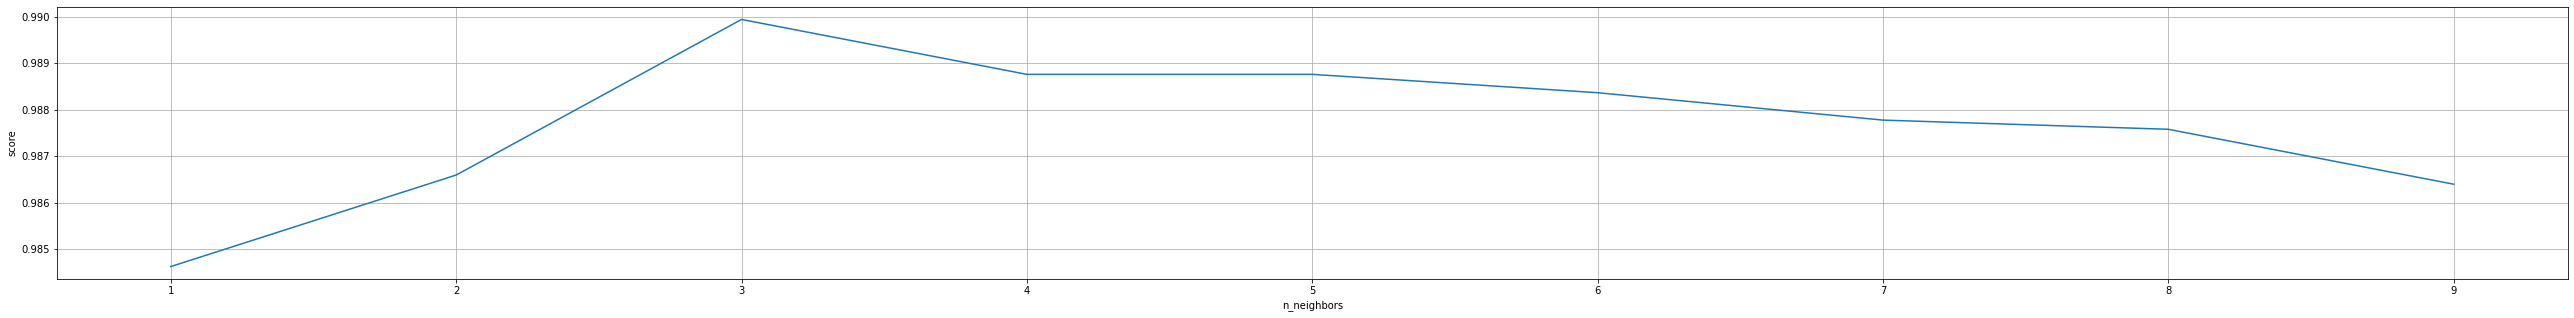

In [28]:
# 1~10 중에서 자장 좋은 k값을 알아보기 위해서이다. 
score_list=[]

for k in range(1,10): # 이웃이 작으면 복잡, 크면 단순
    knn_model = KNeighborsClassifier(n_neighbors=k) # 이웃의 수에 따른 모델 생성
    knn_result = cross_val_score(knn_model, X_train, Y_train) # 교차검증값
    score_list.append(knn_result.mean())

# 시각화
plt.figure(figsize=(45,5))
plt.plot(range(1,10),score_list)
plt.xticks(range(1,10))
plt.grid()
plt.xlabel('n_neighbors')
plt.ylabel('score')
plt.show()



In [32]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
final_knn = KNeighborsClassifier(n_neighbors=3)
final_knn.fit(X_train,Y_train)

#활용데이터 
knn_model = KNeighborsClassifier(n_neighbors=3, metric="euclidean")
knn_model.fit(X_train, Y_train)
Y_pred = knn_model.predict(X_test)
print("accuracy : {:.3f}".format(knn_model.score(X_train, Y_train)))
print(classification_report(Y_test,Y_pred))

accuracy : 0.993
              precision    recall  f1-score   support

           남       0.98      0.99      0.98       618
           여       0.99      0.98      0.99       651

    accuracy                           0.99      1269
   macro avg       0.98      0.99      0.99      1269
weighted avg       0.99      0.99      0.99      1269



In [37]:
knn_model_auc =roc_auc_score(Y_test, knn_model.predict_proba(X_test)[:,1])
print("knn AUC score: {:.3}".format(knn_model_auc))

knn AUC score: 0.992
